
# Assignment - 3

Compare Linear Regression Models with Default vs. Custom Parameters for Earthquake Magnitude Prediction

## Objective

Train and analyze two linear regression models to predict earthquake Magnitude: one with default parameters and one with custom-tuned parameters. Compare their performances and interpret findings, and last provide a summary report.

In [1]:
# Step 1: Install/Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Step 2: Load or Create Dataset
np.random.seed(42)
n = 1500

df = pd.DataFrame({
    "latitude": np.random.uniform(-90, 90, n),
    "longitude": np.random.uniform(-180, 180, n),
    "depth_km": np.random.exponential(80, n),
    "distance_to_boundary_km": np.random.exponential(200, n),
    "fault_slip_rate_mm_yr": np.random.gamma(2.0, 5.0, n),
    "year": np.random.randint(1980, 2025, n),
    "hour": np.random.randint(0, 24, n)
})

# Generate synthetic target magnitude
noise = np.random.normal(0, 0.3, n)
df["magnitude"] = (
    3
    + 1.2 * np.log1p(df["fault_slip_rate_mm_yr"])
    + 0.8 * np.exp(-df["distance_to_boundary_km"] / 300)
    + 0.6 * np.exp(-df["depth_km"] / 200)
    - 0.001 * (df["latitude"].abs() + df["longitude"].abs())
    + 0.0005 * (df["year"] - 2000)
    + 0.02 * np.sin(2 * np.pi * df["hour"] / 24)
    + noise
).clip(2.5, 8.9)

print(df.head())

    latitude   longitude    depth_km  distance_to_boundary_km  \
0 -22.582779    6.869443   89.350980               182.908096   
1  81.128575   -7.494524  127.438485               144.189143   
2  41.758910 -170.768856   23.064491                67.987313   
3  17.758527  -57.150782   78.439486                 1.297068   
4 -61.916645  -43.129577   67.843101               137.130754   

   fault_slip_rate_mm_yr  year  hour  magnitude  
0               3.240379  2019    13   5.181585  
1              11.777908  2001    22   6.803287  
2               4.199743  2001    20   5.771445  
3               8.554788  1995    15   6.716463  
4              12.151383  2006    23   7.225088  


In [3]:
# Step 3: Train-Test Split
X = df.drop(columns=["magnitude"])
y = df["magnitude"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [4]:
# Step 4: Define Models
# Model A: Default Linear Regression
model_a = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# Model B: Custom - Polynomial Features + Positive Coefficients
model_b = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler(with_mean=False)),
    ("linreg", LinearRegression(positive=True))
])

In [5]:
# Step 5: Train Models
model_a.fit(X_train, y_train)
model_b.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler(with_mean=False)),
                ('linreg', LinearRegression(positive=True))])

In [6]:
# Step 6: Evaluate
def evaluate(model, X_tr, y_tr, X_te, y_te, name):
    yhat_train = model.predict(X_tr)
    yhat_test = model.predict(X_te)
    metrics = {
        "Model": name,
        "Train R2": r2_score(y_tr, yhat_train),
        "Test R2": r2_score(y_te, yhat_test),
        "Test MAE": mean_absolute_error(y_te, yhat_test),
        "Test RMSE": np.sqrt(mean_squared_error(y_te, yhat_test))  # works in all sklearn versions
    }
    return metrics, yhat_test

In [7]:
metrics_a, yhat_test_a = evaluate(model_a, X_train, y_train, X_test, y_test, "Default")
metrics_b, yhat_test_b = evaluate(model_b, X_train, y_train, X_test, y_test, "Custom")

results = pd.DataFrame([metrics_a, metrics_b])
print(results)

     Model  Train R2   Test R2  Test MAE  Test RMSE
0  Default  0.745455  0.747745  0.339083   0.437349
1   Custom  0.701917  0.652960  0.399529   0.512977


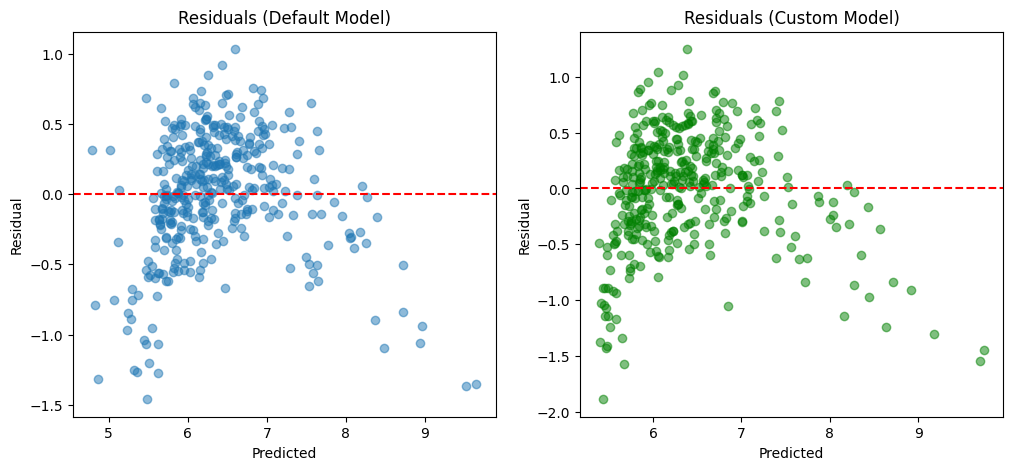

In [8]:
# Step 7: Visualizations
# Residual plots
residuals_a = y_test - yhat_test_a
residuals_b = y_test - yhat_test_b

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(yhat_test_a, residuals_a, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals (Default Model)")
plt.xlabel("Predicted")
plt.ylabel("Residual")

plt.subplot(1,2,2)
plt.scatter(yhat_test_b, residuals_b, alpha=0.5, color="green")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals (Custom Model)")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

In [9]:
# Step 8: Summary
print("Summary Report:")
print("Default Model vs Custom Model performance comparison:")
print(results)

Summary Report:
Default Model vs Custom Model performance comparison:
     Model  Train R2   Test R2  Test MAE  Test RMSE
0  Default  0.745455  0.747745  0.339083   0.437349
1   Custom  0.701917  0.652960  0.399529   0.512977
